# Recursive Forecasting

In [1]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, TargetEncoder
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
import joblib
import pickle
import optuna
import cloudpickle
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
test_data = pd.read_csv('../../data/raw/TEST_FINAL.csv', parse_dates=['Date'])
train_data = pd.read_csv('../../data/raw/train.csv', parse_dates=['Date'])
clusters = pd.read_csv('../../data/processed/store_cluster.csv')

In [3]:
train_data = train_data.merge(clusters, on='Store_id', how='left')
test_data = test_data.merge(clusters, on='Store_id', how='left')

In [123]:
train_data[(train_data["Date"] > train_data["Date"].max() - pd.DateOffset(days=30))]

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,Orders,Sales,cluster
177390,T1177391,155,S3,L1,R2,2019-05-02,0,No,110,76296.00,1
177391,T1177392,108,S1,L1,R4,2019-05-02,0,Yes,81,63402.00,3
177392,T1177393,4,S1,L1,R2,2019-05-02,0,Yes,84,56964.00,3
177393,T1177394,206,S1,L1,R1,2019-05-02,0,No,73,54249.00,3
177394,T1177395,141,S1,L1,R2,2019-05-02,0,No,52,37065.00,3
...,...,...,...,...,...,...,...,...,...,...,...
188335,T1188336,149,S2,L3,R2,2019-05-31,1,Yes,51,37272.00,4
188336,T1188337,153,S4,L2,R1,2019-05-31,1,No,90,54572.64,2
188337,T1188338,154,S1,L3,R2,2019-05-31,1,No,56,31624.56,3
188338,T1188339,155,S3,L1,R2,2019-05-31,1,Yes,70,49162.41,1


In [129]:
deploy_data = test_data.copy()
deploy_data[["Orders", "Sales"]] = np.nan, np.nan
deploy_data = pd.concat([train_data[(train_data["Date"] > train_data["Date"].max() - pd.DateOffset(days=30))], deploy_data])

In [130]:
deploy_data

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,Orders,Sales,cluster
177390,T1177391,155,S3,L1,R2,2019-05-02,0,No,110.0,76296.0,1
177391,T1177392,108,S1,L1,R4,2019-05-02,0,Yes,81.0,63402.0,3
177392,T1177393,4,S1,L1,R2,2019-05-02,0,Yes,84.0,56964.0,3
177393,T1177394,206,S1,L1,R1,2019-05-02,0,No,73.0,54249.0,3
177394,T1177395,141,S1,L1,R2,2019-05-02,0,No,52.0,37065.0,3
...,...,...,...,...,...,...,...,...,...,...,...
22260,T1210601,186,S2,L5,R2,2019-07-31,0,No,NaN,NaN,4
22261,T1210602,11,S4,L2,R1,2019-07-31,0,No,NaN,NaN,2
22262,T1210603,185,S1,L1,R3,2019-07-31,0,Yes,NaN,NaN,3
22263,T1210604,69,S1,L1,R4,2019-07-31,0,No,NaN,NaN,3


In [7]:
study = optuna.create_study(direction="minimize", storage="sqlite:///optuna.db", study_name="LightGBM", load_if_exists=True)

[I 2025-01-10 17:08:00,422] Using an existing study with name 'LightGBM' instead of creating a new one.


In [8]:
print("Min date:", train_data["Date"].min(), ", Max date:", train_data["Date"].max())

total_days = (train_data["Date"].max() - train_data["Date"].min()).days
train_max = train_data["Date"].min() + pd.DateOffset(days=total_days * 0.8)
print("Total days:", total_days, ", Training days: ",total_days * 0.8 )
print("Train max date:", train_max)

Min date: 2018-01-01 00:00:00 , Max date: 2019-05-31 00:00:00
Total days: 515 , Training days:  412.0
Train max date: 2019-02-17 00:00:00


In [9]:
test_data = train_data[train_data["Date"] > train_max - pd.DateOffset(days=30)]
train_data = train_data[train_data["Date"] <= train_max]

In [140]:
train_data

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,Orders,Sales,cluster
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84,3
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12,2
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20,1
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16,4
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52,4
...,...,...,...,...,...,...,...,...,...,...,...
188335,T1188336,149,S2,L3,R2,2019-05-31,1,Yes,51,37272.00,4
188336,T1188337,153,S4,L2,R1,2019-05-31,1,No,90,54572.64,2
188337,T1188338,154,S1,L3,R2,2019-05-31,1,No,56,31624.56,3
188338,T1188339,155,S3,L1,R2,2019-05-31,1,Yes,70,49162.41,1


In [11]:
test_data

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,Orders,Sales,cluster
139795,T1139796,209,S1,L1,R1,2019-01-19,0,No,51,29571.00,3
139796,T1139797,156,S1,L1,R3,2019-01-19,0,No,75,44649.00,3
139797,T1139798,286,S4,L2,R4,2019-01-19,0,No,33,20046.00,2
139798,T1139799,73,S3,L2,R4,2019-01-19,0,No,67,42246.00,1
139799,T1139800,213,S1,L1,R2,2019-01-19,0,No,65,37506.00,3
...,...,...,...,...,...,...,...,...,...,...,...
188335,T1188336,149,S2,L3,R2,2019-05-31,1,Yes,51,37272.00,4
188336,T1188337,153,S4,L2,R1,2019-05-31,1,No,90,54572.64,2
188337,T1188338,154,S1,L3,R2,2019-05-31,1,No,56,31624.56,3
188338,T1188339,155,S3,L1,R2,2019-05-31,1,Yes,70,49162.41,1


In [158]:
forecast_df = test_data[test_data["Store_id"]==4]
# forecast_df = forecast_df[forecast_df["Date"] > train_max - pd.DateOffset(days=30)]

In [159]:
forecast_df = deploy_data[deploy_data["Store_id"]==5]

In [141]:
train_data

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,Orders,Sales,cluster
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84,3
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12,2
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20,1
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16,4
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52,4
...,...,...,...,...,...,...,...,...,...,...,...
188335,T1188336,149,S2,L3,R2,2019-05-31,1,Yes,51,37272.00,4
188336,T1188337,153,S4,L2,R1,2019-05-31,1,No,90,54572.64,2
188337,T1188338,154,S1,L3,R2,2019-05-31,1,No,56,31624.56,3
188338,T1188339,155,S3,L1,R2,2019-05-31,1,Yes,70,49162.41,1


In [160]:
forecast_df

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,Orders,Sales,cluster
177588,T1177589,5,S1,L1,R3,2019-05-02,0,No,78.0,52962.0,3
177782,T1177783,5,S1,L1,R3,2019-05-03,0,Yes,91.0,64221.0,3
178263,T1178264,5,S1,L1,R3,2019-05-04,0,Yes,103.0,71742.0,3
178542,T1178543,5,S1,L1,R3,2019-05-05,0,Yes,102.0,75105.0,3
179119,T1179120,5,S1,L1,R3,2019-05-06,0,Yes,88.0,67947.0,3
...,...,...,...,...,...,...,...,...,...,...,...
20750,T1209091,5,S1,L1,R3,2019-07-27,0,Yes,NaN,NaN,3
21127,T1209468,5,S1,L1,R3,2019-07-28,0,Yes,NaN,NaN,3
21304,T1209645,5,S1,L1,R3,2019-07-29,0,Yes,NaN,NaN,3
21591,T1209932,5,S1,L1,R3,2019-07-30,0,No,NaN,NaN,3


In [143]:
class FeatureGenerator(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.dropped_indices_ = None  # To store the indices of dropped rows
        self.included_indices_ = None  # To store the indices of included rows

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        result = X.copy()
        result = result.drop(columns=['ID', 'Orders'], axis=1, errors='ignore')
        result = result.sort_values(by=['Store_id', 'Date'])
        # result = result.merge(clusters, on='Store_id', how='left')
        result['Day'] = result['Date'].dt.day
        result["Day_of_Week"] = result["Date"].dt.dayofweek
        result["Month"] = result["Date"].dt.month
        result["Year"] = result["Date"].dt.year
        result["Quarter"] = result["Date"].dt.quarter
        result["Week"] = result["Date"].dt.isocalendar().week
        result["Week_of_Month"] = result["Date"].dt.day.apply(lambda x: (x-1) // 7 + 1)
        result["Is_Weekend"] = result["Day_of_Week"].apply(lambda x: 1 if x >= 5 else 0)
        result["Discount"] = result["Discount"].apply(lambda x: 1 if x == 'Yes' else 0)

        # Create lag features
        result['Sales_Lag_1'] = result.groupby('Store_id')['Sales'].shift(1)
        result['Sales_Lag_7'] = result.groupby('Store_id')['Sales'].shift(7)
        result['Sales_Lag_12'] = result.groupby('Store_id')['Sales'].shift(12)
        result['Sales_Lag_30'] = result.groupby('Store_id')['Sales'].shift(30)

        # Create moving average features
        result['Sales_Mean_7'] = result.groupby('Store_id')['Sales'].shift(1).rolling(window=7).mean()
        result['Sales_Mean_12'] = result.groupby('Store_id')['Sales'].shift(1).rolling(window=12).mean()
        result['Sales_Mean_30'] = result.groupby('Store_id')['Sales'].shift(1).rolling(window=30).mean()

        # Create moving standard deviation features
        result['Sales_Std_7'] = result.groupby('Store_id')['Sales'].shift(1).rolling(window=7).std()
        result['Sales_Std_12'] = result.groupby('Store_id')['Sales'].shift(1).rolling(window=12).std()
        result['Sales_Std_30'] = result.groupby('Store_id')['Sales'].shift(1).rolling(window=30).std()

        # Create moving min and max features
        result['Sales_Min_7'] = result.groupby('Store_id')['Sales'].shift(1).rolling(window=7).min()
        result['Sales_Min_12'] = result.groupby('Store_id')['Sales'].shift(1).rolling(window=12).min()
        result['Sales_Min_30'] = result.groupby('Store_id')['Sales'].shift(1).rolling(window=30).min()

        result['Sales_Max_7'] = result.groupby('Store_id')['Sales'].shift(1).rolling(window=7).max()
        result['Sales_Max_12'] = result.groupby('Store_id')['Sales'].shift(1).rolling(window=12).max()
        result['Sales_Max_30'] = result.groupby('Store_id')['Sales'].shift(1).rolling(window=30).max()


        # Create expanding mean and standard deviation features
        result['Sales_Expanding_Mean'] = result.groupby('Store_id')['Sales'].shift(1).ewm(alpha=0.9, adjust=False).mean()
        result['Sales_Expanding_Std'] = result.groupby('Store_id')['Sales'].shift(1).ewm(alpha=0.9, adjust=False).std()
        result['Sales_Expanding_Sum'] = result.groupby('Store_id')['Sales'].expanding().sum().shift(1).reset_index(level=0, drop=True)


        result = result.drop(columns=["Date","Store_id"], axis=1)
        # encode cyclical features
        result['Day_sin'] = np.sin(2 * np.pi * result['Day']/31)
        result['Day_cos'] = np.cos(2 * np.pi * result['Day']/31)

        result['Day_of_Week_sin'] = np.sin(2 * np.pi * result['Day_of_Week']/6)
        result['Day_of_Week_cos'] = np.cos(2 * np.pi * result['Day_of_Week']/6)

        result['Month_sin'] = np.sin(2 * np.pi * result['Month']/12)
        result['Month_cos'] = np.cos(2 * np.pi * result['Month']/12)

        result['Quarter_sin'] = np.sin(2 * np.pi * result['Quarter']/4)
        result['Quarter_cos'] = np.cos(2 * np.pi * result['Quarter']/4)

        result['Week_sin'] = np.sin(2 * np.pi * result['Week']/52)
        result['Week_cos'] = np.cos(2 * np.pi * result['Week']/52)

        result['Week_of_Month_sin'] = np.sin(2 * np.pi * result['Week_of_Month']/5)
        result['Week_of_Month_cos'] = np.cos(2 * np.pi * result['Week_of_Month']/5)

        # drop original cyclical features
        result = result.drop(columns=['Day', 'Day_of_Week', 'Month', 'Quarter', 'Week', 'Week_of_Month', 'Year', 'Sales'], axis=1)
        
        self.dropped_indices_ = result.index[result.isnull().any(axis=1)].tolist()
        result = result.dropna()
        self.included_indices_ = result.index.tolist()
        
        return result


In [144]:
df = train_data.copy()

In [145]:
df

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,Orders,Sales,cluster
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84,3
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12,2
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20,1
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16,4
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52,4
...,...,...,...,...,...,...,...,...,...,...,...
188335,T1188336,149,S2,L3,R2,2019-05-31,1,Yes,51,37272.00,4
188336,T1188337,153,S4,L2,R1,2019-05-31,1,No,90,54572.64,2
188337,T1188338,154,S1,L3,R2,2019-05-31,1,No,56,31624.56,3
188338,T1188339,155,S3,L1,R2,2019-05-31,1,Yes,70,49162.41,1


In [146]:
target_encoder = TargetEncoder()
df["Store_id_enc"] = target_encoder.fit_transform(df[["Store_id"]], df["Sales"])

In [147]:
pipeline = Pipeline([

    ('feature_generator', FeatureGenerator()),
    ('categorical_encoder', ColumnTransformer([
        ('onehot', OneHotEncoder(), ['Store_Type', 'Location_Type', 'Region_Code', 'cluster']),
    ], remainder='passthrough', verbose_feature_names_out=False)),
    ('scaler', StandardScaler())
])
pipeline

transformed_df = pipeline.fit_transform(df)
transformed_df = pd.DataFrame(transformed_df, columns=pipeline[1].get_feature_names_out())
transformed_df

,Store_Type_S1,Store_Type_S2,Store_Type_S3,Store_Type_S4,Location_Type_L1,Location_Type_L2,Location_Type_L3,Location_Type_L4,Location_Type_L5,Region_Code_R1,...,Day_of_Week_sin,Day_of_Week_cos,Month_sin,Month_cos,Quarter_sin,Quarter_cos,Week_sin,Week_cos,Week_of_Month_sin,Week_of_Month_cos
0,1.059289,-0.425711,-0.389127,-0.567859,-0.908295,-0.588951,2.300675,-0.247076,-0.282633,1.394112,...,1.322196e+00,-0.858545,0.427633,1.371855,1.266250,0.176943,0.507146,1.246661,-2.456339e-16,1.820332
1,1.059289,-0.425711,-0.389127,-0.567859,-0.908295,-0.588951,2.300675,-0.247076,-0.282633,1.394112,...,1.374464e-16,-1.531533,0.942549,0.828022,1.266250,0.176943,0.507146,1.246661,1.252984e+00,0.728725
2,1.059289,-0.425711,-0.389127,-0.567859,-0.908295,-0.588951,2.300675,-0.247076,-0.282633,1.394112,...,-1.322196e+00,-0.858545,0.942549,0.828022,1.266250,0.176943,0.507146,1.246661,1.252984e+00,0.728725
3,1.059289,-0.425711,-0.389127,-0.567859,-0.908295,-0.588951,2.300675,-0.247076,-0.282633,1.394112,...,-1.322196e+00,0.487432,0.942549,0.828022,1.266250,0.176943,0.507146,1.246661,1.252984e+00,0.728725
4,1.059289,-0.425711,-0.389127,-0.567859,-0.908295,-0.588951,2.300675,-0.247076,-0.282633,1.394112,...,-4.234688e-16,1.160420,0.942549,0.828022,1.266250,0.176943,0.507146,1.246661,1.252984e+00,0.728725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177385,-0.944030,2.349012,-0.389127,-0.567859,1.100964,-0.588951,-0.434655,-0.247076,-0.282633,-0.717302,...,-4.952533e-17,1.160420,0.427633,-1.201591,-0.171595,-1.256293,0.362158,-1.302586,-1.252984e+00,0.728725
177386,-0.944030,2.349012,-0.389127,-0.567859,1.100964,-0.588951,-0.434655,-0.247076,-0.282633,-0.717302,...,1.322196e+00,0.487432,0.427633,-1.201591,-0.171595,-1.256293,0.362158,-1.302586,-1.252984e+00,0.728725
177387,-0.944030,2.349012,-0.389127,-0.567859,1.100964,-0.588951,-0.434655,-0.247076,-0.282633,-0.717302,...,1.322196e+00,-0.858545,0.427633,-1.201591,-0.171595,-1.256293,0.362158,-1.302586,-2.456339e-16,1.820332
177388,-0.944030,2.349012,-0.389127,-0.567859,1.100964,-0.588951,-0.434655,-0.247076,-0.282633,-0.717302,...,1.374464e-16,-1.531533,0.427633,-1.201591,-0.171595,-1.256293,0.362158,-1.302586,-2.456339e-16,1.820332


In [148]:
assert 'Store_id_enc' in transformed_df.columns

In [149]:

lgbm = LGBMRegressor(**study.best_params, n_jobs=-1, random_state=42, num_threads=-1, boosting_type="goss", data_sample_strategy="goss")
lgbm.fit(transformed_df, df.iloc[pipeline[0].included_indices_]["Sales"])

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5352
[LightGBM] [Info] Number of data points in the train set: 177390, number of used features: 52
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 42635.969587


LGBMRegressor(boosting_type='goss', data_sample_strategy='goss',
              learning_rate=0.06969300936939352, max_depth=19, n_estimators=197,
              n_jobs=-1, num_leaves=61, num_threads=-1, random_state=42,
              subsample=0.8296658570736767)

In [125]:
transformed_forecast_data = forecast_df.copy()
transformed_forecast_data["Store_id_enc"] = target_encoder.transform(forecast_df[["Store_id"]])
transformed_forecast_data

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,Orders,Sales,cluster,Store_id_enc
139927,T1139928,1,S1,L3,R1,2019-01-19,0,No,38,21420.00,3,34591.233809
140430,T1140431,1,S1,L3,R1,2019-01-20,0,No,56,30744.00,3,34591.233809
140833,T1140834,1,S1,L3,R1,2019-01-21,0,No,51,26475.00,3,34591.233809
141152,T1141153,1,S1,L3,R1,2019-01-22,0,No,65,33921.00,3,34591.233809
141334,T1141335,1,S1,L3,R1,2019-01-23,0,No,57,30447.00,3,34591.233809
...,...,...,...,...,...,...,...,...,...,...,...,...
186569,T1186570,1,S1,L3,R1,2019-05-27,0,Yes,53,33075.00,3,34591.233809
187165,T1187166,1,S1,L3,R1,2019-05-28,0,Yes,57,37317.00,3,34591.233809
187391,T1187392,1,S1,L3,R1,2019-05-29,0,Yes,69,44652.00,3,34591.233809
187962,T1187963,1,S1,L3,R1,2019-05-30,0,Yes,66,42387.00,3,34591.233809


In [126]:
transformed_forecast_data = pipeline.transform(transformed_forecast_data)

In [128]:
lgbm.predict(transformed_forecast_data[0].reshape(1, -1))[0]

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


38626.18095682897

In [133]:
forecast_df[forecast_df["Date"] == pd.to_datetime("2019-02-18")]["Sales"]=lgbm.predict(transformed_forecast_data[0].reshape(1, -1))[0]

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


/var/folders/jf/1r7jb1_s6ys1p0n0n56s2qsh0000gn/T/ipykernel_8434/3478290247.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_df[forecast_df["Date"] == pd.to_datetime("2019-02-18")]["Sales"]=lgbm.predict(transformed_forecast_data[0].reshape(1, -1))[0]


In [150]:
forecast_df

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,Orders,Sales,cluster
177522,T1177523,1,S1,L3,R1,2019-05-02,0,No,53.0,34710.0,3
178030,T1178031,1,S1,L3,R1,2019-05-03,0,Yes,80.0,52362.0,3
178360,T1178361,1,S1,L3,R1,2019-05-04,0,Yes,94.0,66564.0,3
178556,T1178557,1,S1,L3,R1,2019-05-05,0,Yes,116.0,79806.0,3
179090,T1179091,1,S1,L3,R1,2019-05-06,0,Yes,88.0,64491.0,3
...,...,...,...,...,...,...,...,...,...,...,...
20746,T1209087,1,S1,L3,R1,2019-07-27,0,Yes,NaN,NaN,3
21166,T1209507,1,S1,L3,R1,2019-07-28,0,Yes,NaN,NaN,3
21417,T1209758,1,S1,L3,R1,2019-07-29,0,Yes,NaN,NaN,3
21623,T1209964,1,S1,L3,R1,2019-07-30,0,No,NaN,NaN,3


In [151]:
def transform_predict(data):
    data = data.copy()  
    data.loc[:, "Store_id_enc"] = target_encoder.transform(data[["Store_id"]])
    data = pipeline.transform(data)
    return lgbm.predict(data.reshape(1, -1))[0]

In [161]:
editable_data = forecast_df.copy()
predictions = []

for i in range(0, 60):
    last_31_data =editable_data.iloc[i:i+31]
    prediction_date = last_31_data.iloc[-1]["Date"]
    print("Predicting for date: ", prediction_date)
    prediction = transform_predict(last_31_data)
    print("Prediction: ", prediction)
    predictions.append({
        "Date": prediction_date,
        "Predicted_Sales": prediction
    })
    editable_data.loc[editable_data["Date"] == prediction_date, "Sales"] = prediction    

Predicting for date:  2019-06-01 00:00:00
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
Prediction:  47131.95828864239
Predicting for date:  2019-06-02 00:00:00
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
Prediction:  53799.322911932824
Predicting for date:  2019-06-03 00:00:00
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
Prediction:  43425.246482883806
Predicting for date:  2019-06-04 00:00:00
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets

In [162]:
out =pd.DataFrame(predictions).merge(forecast_df[["Sales","Date"]], on="Date", how="left")

In [163]:
out

,Date,Predicted_Sales,Sales
0,2019-06-01,47131.958289,NaN
1,2019-06-02,53799.322912,NaN
2,2019-06-03,43425.246483,NaN
3,2019-06-04,39980.294729,NaN
4,2019-06-05,36933.965483,NaN
5,2019-06-06,39213.603030,NaN
6,2019-06-07,35891.746339,NaN
7,2019-06-08,57537.501938,NaN
8,2019-06-09,55463.911044,NaN
9,2019-06-10,48199.168159,NaN


<Axes: xlabel='Date', ylabel='Sales'>

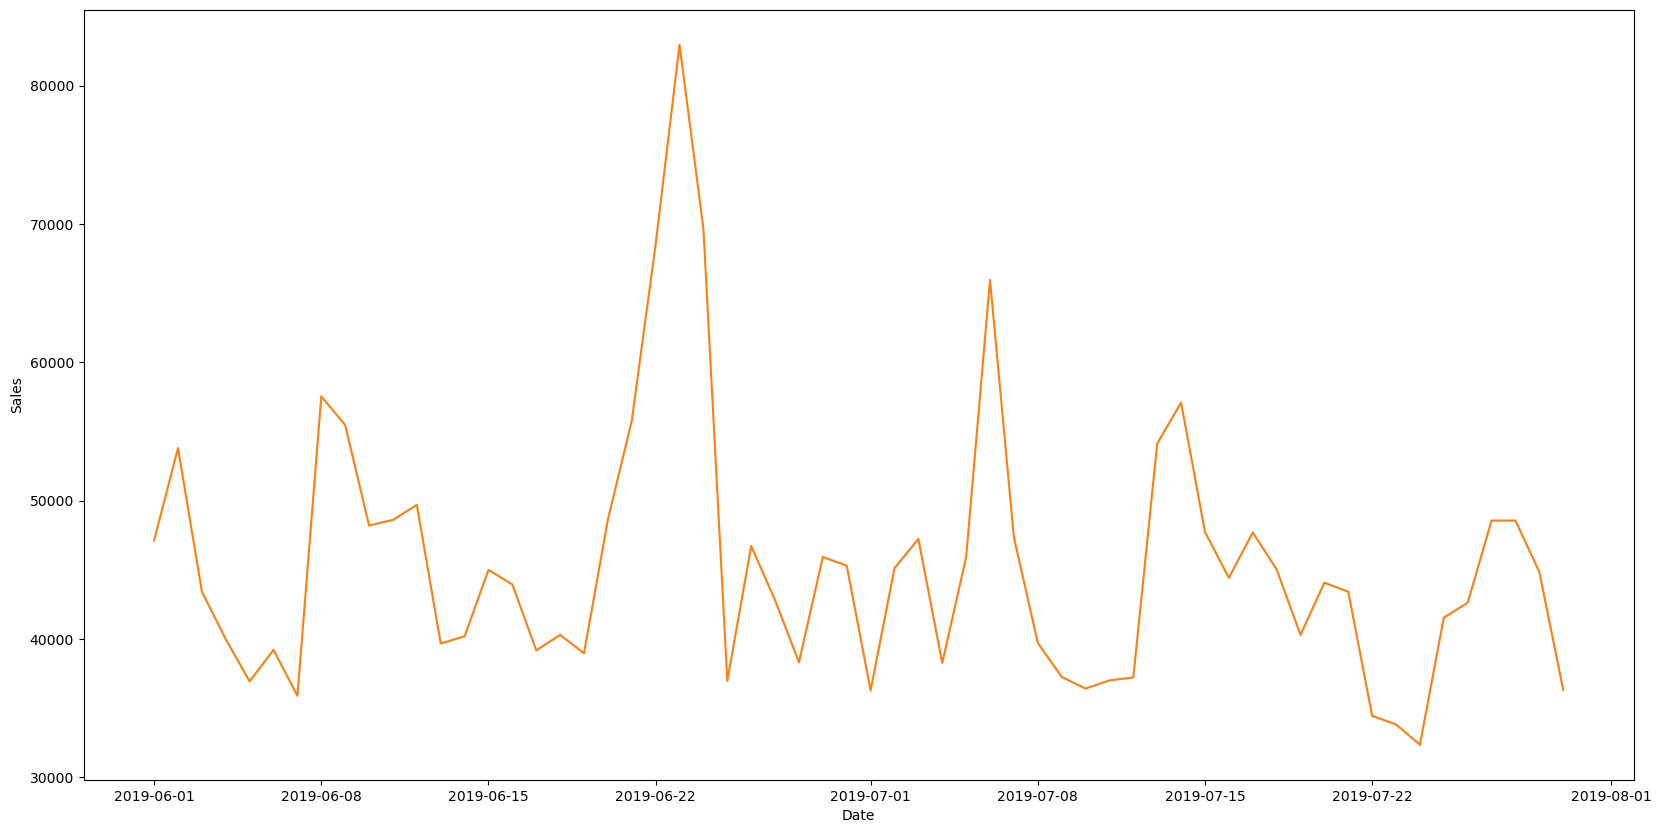

In [164]:
plt.figure(figsize=(20,10))
sns.lineplot(data=out, x="Date", y="Sales")
sns.lineplot(data=out, x="Date", y="Predicted_Sales")

(17897.0, 18109.0)

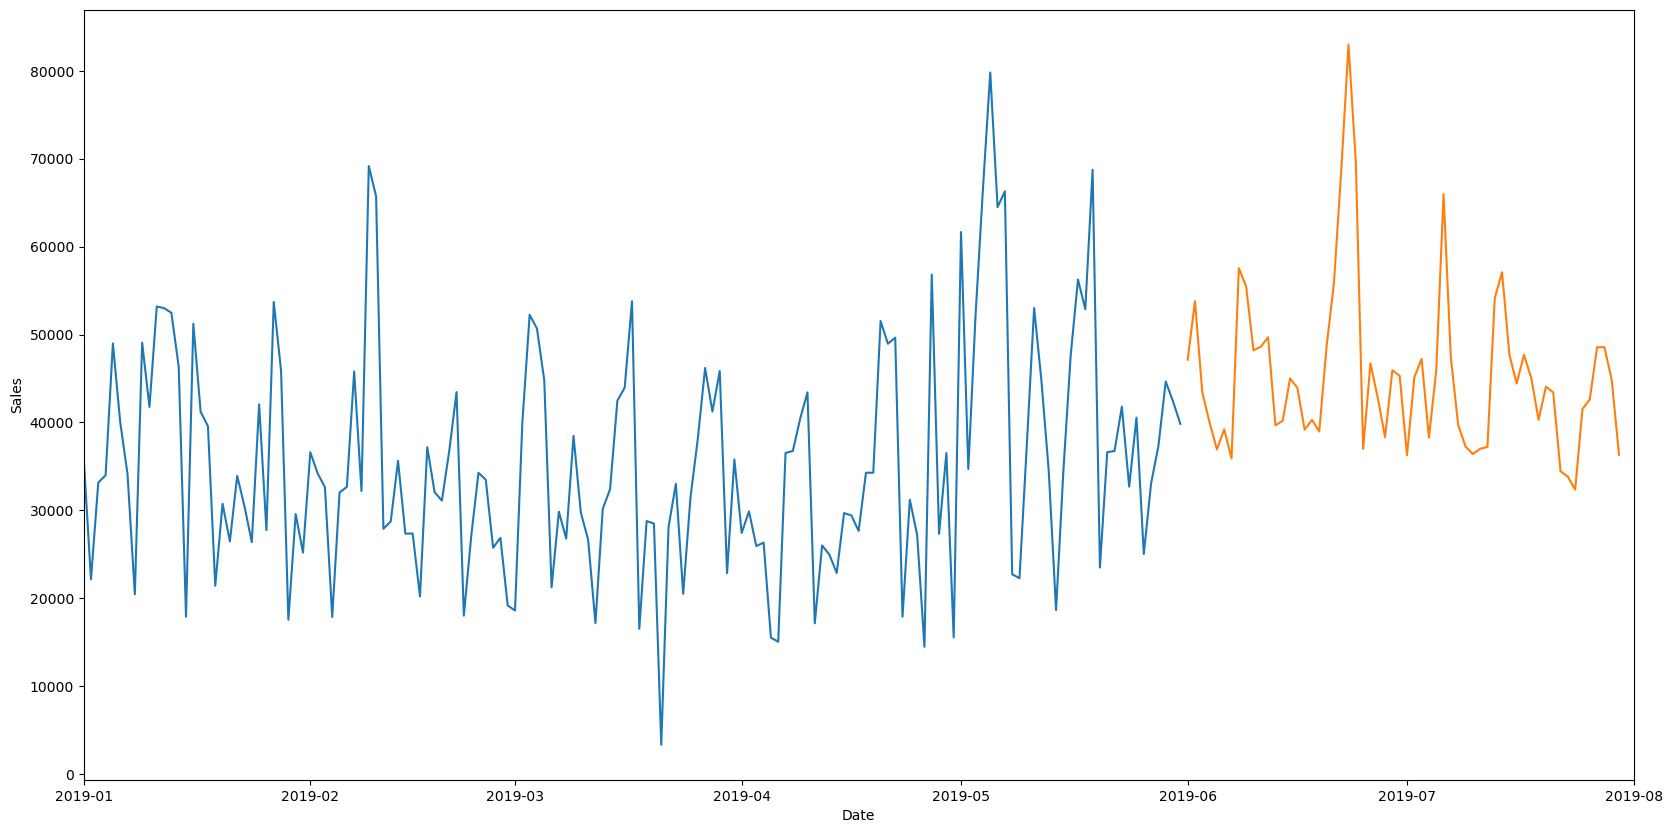

In [165]:
plt.figure(figsize=(20,10))
sns.lineplot(data=train_data[train_data["Store_id"]==1], x="Date", y="Sales")
sns.lineplot(data=out, x="Date", y="Predicted_Sales")
plt.xlim(pd.to_datetime("2019-01-01"), pd.to_datetime("2019-08-01"))

In [167]:
# save pipeline
# joblib.dump(pipeline, '../../deploy/models/pipeline.joblib')
# # save model
# joblib.dump(lgbm, '../../deploy/models/model_lgbm.joblib')

# cloudpickle
with open('../../deploy/models/target_encoder.pkl', 'wb') as f:
    cloudpickle.dump(target_encoder, f)

with open('../../deploy/models/pipeline.pkl', 'wb') as f:
    cloudpickle.dump(pipeline, f)

with open('../../deploy/models/model_lgbm.pkl', 'wb') as f:
    cloudpickle.dump(lgbm, f)

In [168]:
deploy_data.to_parquet('../../deploy/data/deploy_data.parquet')

In [4]:
train_data[train_data['Date'] >= pd.to_datetime(first_forecast_date) - pd.Timedelta('30 days')].to_parquet('../../deploy/data/train_data.parquet')

In [5]:
train_data[["Store_id","Sales","Date"]].to_parquet('../../deploy/data/train_data.parquet')

In [33]:
test_data[test_data['Date'] <= pd.to_datetime(first_forecast_date) + pd.Timedelta('30 days')].to_parquet('../../deploy/data/test_data.parquet')